In [43]:
import sys
sys.path.append('..')

In [44]:
from src.utils import opts
from src.utils import get_dataset_hash
from src.datasets import DatasetBootstrapper
from src.negative_sampling import neg_sampling

_opts = opts(
    dataset="zhao",
    val_seed=0,
    val_fraction=0.2,
    test_fraction=0.2,
    undirected=False,
    eval_split="edges",
    cuda=False,
    wandb_tracking=False,
)

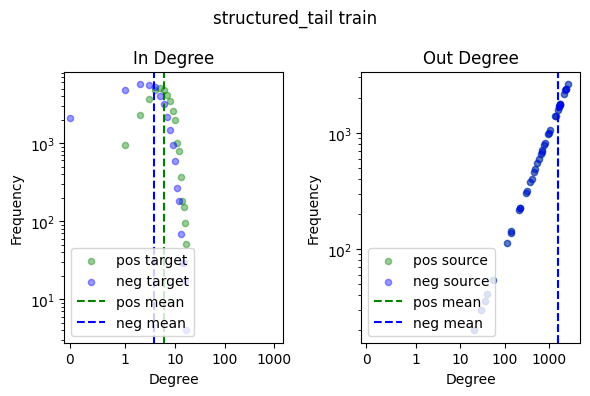

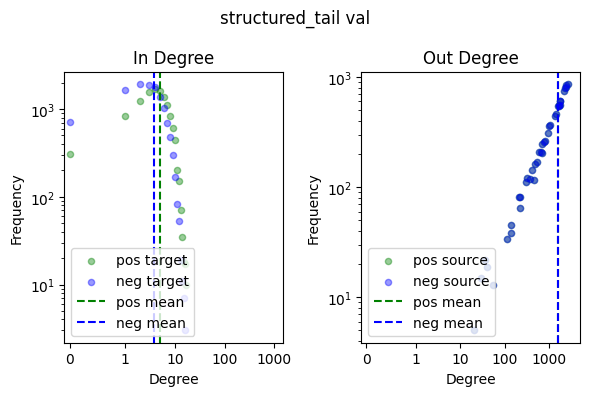

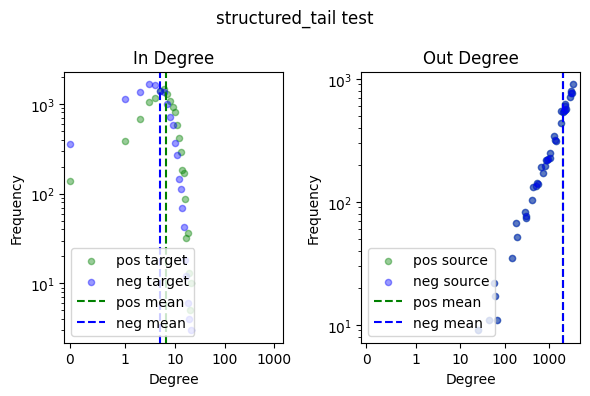

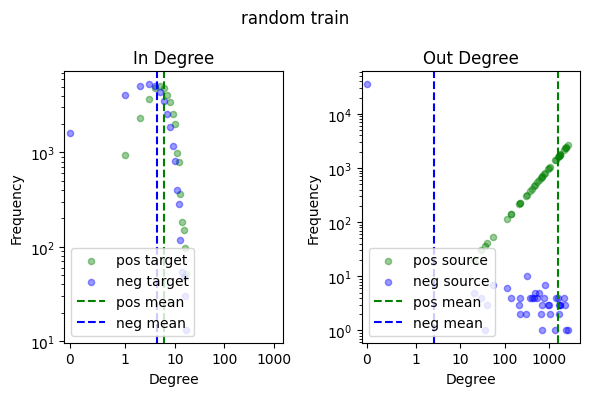

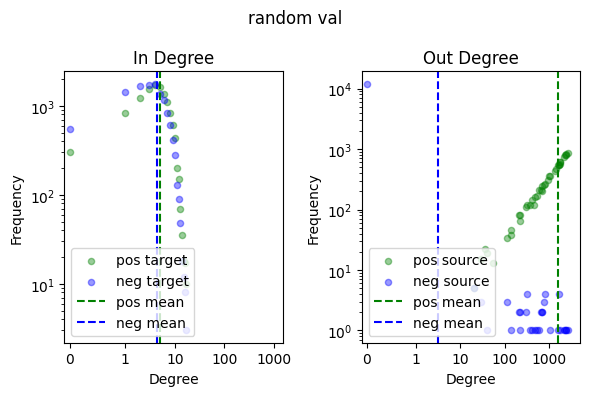

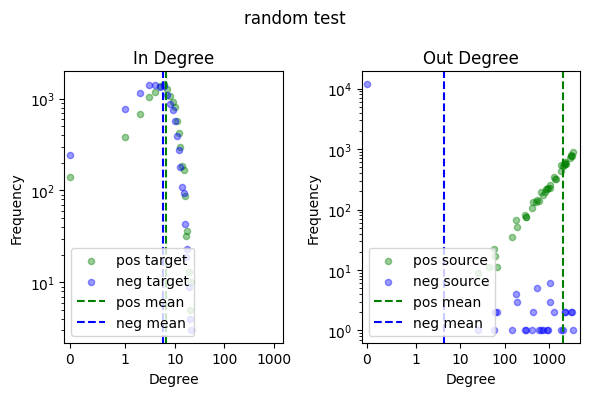

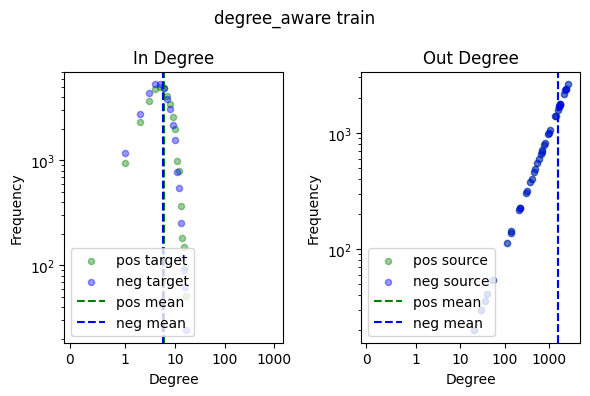

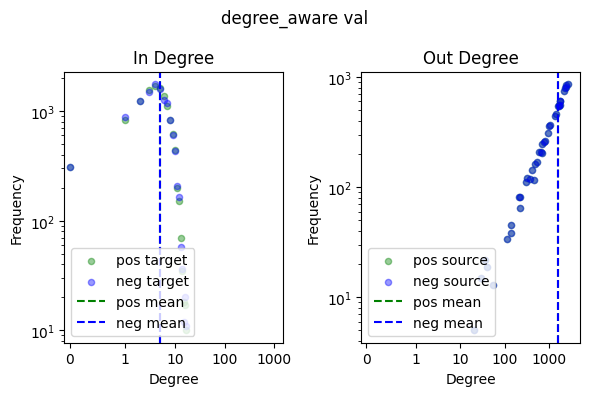

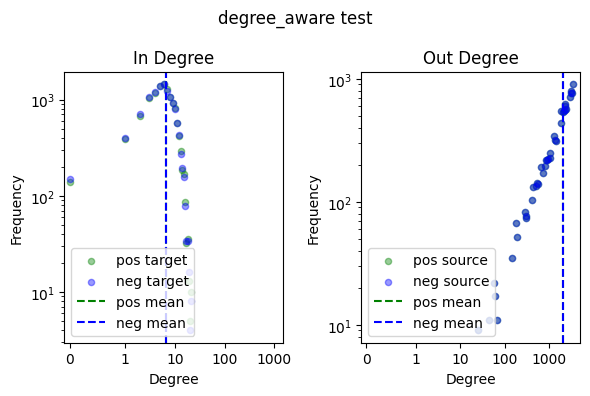

In [49]:
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt

def get_negative_edges(opts, data):
    if opts.negative_sampling == "structured_tail":
        return neg_sampling(data, space="pot_net", type="tail")
    elif opts.negative_sampling == "random":
        return neg_sampling(data, space="full", type="random")
    elif opts.negative_sampling == "degree_aware":
        return neg_sampling(data, space="full", type="degree_aware")

def counts_with_zero(a):
    v, f = np.unique(a, return_counts=True)
    if len(v) == 0 or not np.any(v == 0):
        v = np.insert(v, 0, 0)
        f = np.insert(f, 0, 0)
    return v, f

def plot_deg(ax, pos_arr, neg_arr, title, xlim_right, pos_label, neg_label):
    vp, fp = counts_with_zero(pos_arr)
    vn, fn = counts_with_zero(neg_arr)
    ax.scatter(vp, fp, alpha=0.4, s=20, color='g', label=pos_label)
    ax.scatter(vn, fn, alpha=0.4, s=20, color='b', label=neg_label)
    ax.axvline(np.mean(pos_arr), color='g', linestyle='--', label='pos mean')
    ax.axvline(np.mean(neg_arr), color='b', linestyle='--', label='neg mean')
    ax.set_xscale('symlog', linthresh=1)
    ax.set_yscale('log')
    ax.set_xlim(left=-0.1, right=xlim_right)
    xt = ax.get_xticks()
    if not np.any(np.isclose(xt, 0)):
        xt = np.insert(xt, 0, 0)
    ax.set_xticks(xt)
    ax.set_xticklabels([str(int(x)) if x != 0 else "0" for x in xt])
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(loc="lower left")

for sampling in ["structured_tail", "random", "degree_aware"]:
    _opts.negative_sampling = sampling
    dataset = DatasetBootstrapper(_opts, hash=get_dataset_hash(_opts)).get_dataset()
    train_data = dataset.train_data
    val_data = dataset.val_data
    test_data = dataset.test_data
    train_g = torch_geometric.utils.to_networkx(train_data, to_undirected=False)
    train_in = np.array([d for _, d in train_g.in_degree()])
    train_out = np.array([d for _, d in train_g.out_degree()])
    test_g = torch_geometric.utils.to_networkx(test_data, to_undirected=False)
    test_in = np.array([d for _, d in test_g.in_degree()])
    test_out = np.array([d for _, d in test_g.out_degree()])
    neg_train = get_negative_edges(_opts, train_data)
    neg_val = get_negative_edges(_opts, val_data)
    neg_test = get_negative_edges(_opts, test_data)
    data = {
        'train': {
            'pos_to_in': train_in[train_data.pos_edges[1]],
            'neg_to_in': train_in[neg_train[1]],
            'pos_from_out': train_out[train_data.pos_edges[0]],
            'neg_from_out': train_out[neg_train[0]],
        },
        'val': {
            'pos_to_in': train_in[val_data.pos_edges[1]],
            'neg_to_in': train_in[neg_val[1]],
            'pos_from_out': train_out[val_data.pos_edges[0]],
            'neg_from_out': train_out[neg_val[0]],
        },
        'test': {
            'pos_to_in': test_in[test_data.pos_edges[1]],
            'neg_to_in': test_in[neg_test[1]],
            'pos_from_out': test_out[test_data.pos_edges[0]],
            'neg_from_out': test_out[neg_test[0]],
        },
    }
    for split in ["train", "val", "test"]:
        fig, axs = plt.subplots(1, 2, figsize=(6, 4))
        fig.suptitle(f'{_opts.negative_sampling} {split}')
        plot_deg(axs[0], data[split]['pos_to_in'], data[split]['neg_to_in'], 'In Degree', 1500, 'pos target', 'neg target')
        plot_deg(axs[1], data[split]['pos_from_out'], data[split]['neg_from_out'], 'Out Degree', 5000, 'pos source', 'neg source')
        plt.tight_layout()
        plt.savefig(f'outputs/node_degree_plot_{split}_{_opts.negative_sampling}.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

In [ ]:
sampling_types = ["structured_tail", "random", "degree_aware"]
colors_map = {"structured_tail":"#C3FF1D","random":"#53B1FF","degree_aware":"#FA6D97"}
in_diffs = {s: [] for s in sampling_types}
out_diffs = {s: [] for s in sampling_types}
vs, ts = _opts.val_seed, _opts.canonical_test_seed
for seed in range(10):
    _opts.val_seed = seed
    _opts.canonical_test_seed = seed
    for s in sampling_types:
        _opts.negative_sampling = s
        dataset = DatasetBootstrapper(_opts, hash=get_dataset_hash(_opts)).get_dataset()
        test_data = dataset.test_data
        g = torch_geometric.utils.to_networkx(test_data, to_undirected=False)
        indeg = np.array([d for _, d in g.in_degree()])
        outdeg = np.array([d for _, d in g.out_degree()])
        neg = get_negative_edges(_opts, test_data)
        pos_to_in = indeg[test_data.pos_edges[1, :]]
        neg_to_in = indeg[neg[1, :]]
        pos_from_out = outdeg[test_data.pos_edges[0, :]]
        neg_from_out = outdeg[neg[0, :]]
        in_diffs[s].append(float(np.mean(pos_to_in) - np.mean(neg_to_in)))
        out_diffs[s].append(float(np.mean(pos_from_out) - np.mean(neg_from_out)))
_opts.val_seed, _opts.canonical_test_seed = vs, ts
in_means = [np.mean(in_diffs[s]) for s in sampling_types]
in_stds = [np.std(in_diffs[s]) for s in sampling_types]
desired_order_in = ["random", "structured_tail", "degree_aware"]
type_to_index_in = {t: i for i, t in enumerate(sampling_types)}
order_in = [type_to_index_in[t] for t in desired_order_in]
ordered_types_in = [sampling_types[i] for i in order_in]
ordered_in_means = [in_means[i] for i in order_in]
ordered_in_stds = [in_stds[i] for i in order_in]
ordered_in_colors = [colors_map[t] for t in ordered_types_in]


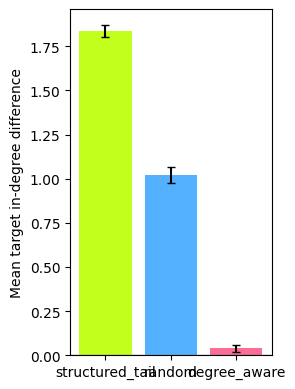

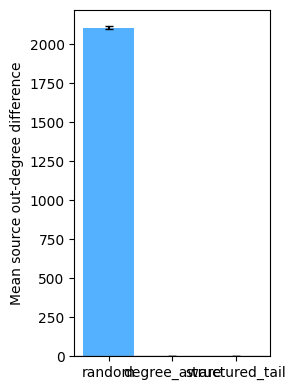

In [51]:
def barplot(labels, means, stds, colors, ylabel, path):
    fig, ax = plt.subplots(figsize=(3, 4))
    x = np.arange(len(labels))
    ax.bar(x, means, yerr=stds, color=colors, capsize=3)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel(ylabel)
    ax.axhline(0.0, color="gray", linewidth=1)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    plt.show()

barplot(ordered_types_in, ordered_in_means, ordered_in_stds, ordered_in_colors, "Mean target in-degree difference", "outputs/test_in_degree_diff_bar_seeds.pdf")
out_means = [np.mean(out_diffs[s]) for s in sampling_types]
out_stds = [np.std(out_diffs[s]) for s in sampling_types]
order_out = np.argsort(out_means)[::-1]
ordered_types_out = [sampling_types[i] for i in order_out]
ordered_out_means = [out_means[i] for i in order_out]
ordered_out_stds = [out_stds[i] for i in order_out]
ordered_out_colors = [colors_map[t] for t in ordered_types_out]
barplot(ordered_types_out, ordered_out_means, ordered_out_stds, ordered_out_colors, "Mean source out-degree difference", "outputs/test_out_degree_diff_bar_seeds.pdf")